In [19]:
import os
import time
import yaml
from collections import Counter

import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from scipy.sparse import lil_matrix,csr_matrix, save_npz, load_npz
import keras.backend as K
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Input, Dropout, Dense
from keras.regularizers import l2
from keras.optimizers import SGD
import matplotlib.pyplot as plt

In [2]:
# Generate the folders for the project
output_path = 'output'
input_path = 'input'
models_dir = os.path.join(output_path, 'models')

if not os.path.exists(output_path):
    os.makedirs(output_path)
    
if not os.path.exists(input_path):
    os.makedirs(input_path)
    
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

In [3]:
# Download the dataset if not existing
!wget -nc http://files.grouplens.org/datasets/movielens/ml-20m.zip
!unzip -n ml-20m.zip

In [4]:
# Preprocessing step
try:
    # Try reading the preprocessed file if existing, if not generate
    ratings_df = pd.read_csv(os.path.join(input_path, 'ratings_preprocessed.csv'))
except:
    # Read the original file
    ratings_df = pd.read_csv(os.path.join('ml-20m', 'ratings.csv'))
    # Make the userId start from zero
    ratings_df['userId'] = ratings_df['userId'] - 1
    # No need the timestamp of the rating
    ratings_df.drop(columns=['timestamp'], inplace=True)
    # Save the new ratings_df
    ratings_df.to_csv(os.path.join(input_path, 'ratings_preprocessed.csv'), index=False)

In [5]:
# Set the subset data from the generic dataset to adapt the training to the hardware size
n = None # 10000
m = None # 2000

if n != None and m != None:
    # Get counter objects to evaluate frequency per userId an movieId
    user_id_count = Counter(ratings_df['userId'])
    movie_id_count = Counter(ratings_df['userId'])
    
    # Get the n and m most common userId and movieIf
    user_ids = [user for user, count in user_id_count.most_common(n)]
    movie_ids = [movie for movie, count in movie_id_count.most_common(m)]
    
    # Filter the dataset according the list of shrinked users and movies
    ratings_lite_df = ratings_df[ratings_df['userId'].isin(user_ids) & 
                                 ratings_df['movieId'].isin(movie_ids)].reset_index().copy()

    # Generate a new mapping adapted to the number of users to adapt the size of the sparse matrix
    new_user_id_map = {old: i for i, old in enumerate(user_ids)}
    new_movie_id_map = {old: j for j, old in enumerate(movie_ids)}

    # Rename the ids of movies and users
    ratings_lite_df.loc[:, 'userId'] = ratings_lite_df.apply(lambda row: new_user_id_map[row['userId']], axis=1)
    ratings_lite_df.loc[:, 'movieId'] = ratings_lite_df.apply(lambda row: new_movie_id_map[row['movieId']], axis=1)
else:
    # In case of using all users and movies just copy the df
    ratings_lite_df = ratings_df.copy()

In [6]:
N = ratings_lite_df['userId'].max() + 1
M = ratings_lite_df['movieId'].max() + 1

N, M

(138493, 131263)

In [7]:
def make_sparse_matrix(N, M, df):
    A = lil_matrix((N, M))
    
    def update_sparse_matrix(row):
        i = int(row['userId'])
        j = int(row['movieId'])
        
        A[i, j] = row['rating']
        
    df.apply(update_sparse_matrix, axis=1)
    
    return A

In [8]:
# Create the sparse matrix for train and test
# lil better for adding new values, csr better for saving
df = shuffle(ratings_lite_df)

cut_off = int(0.8 * len(df.index))
df_train = df.iloc[:cut_off]
df_test = df.iloc[cut_off:]

A_train = make_sparse_matrix(N, M, df_train)
A_train = A_train.tocsr()
mask_train = (A_train > 0) * 1.0
save_npz(os.path.join(input_path, 'A_train.npz'), A_train)

A_test = make_sparse_matrix(N, M, df_test)
A_test = A_test.tocsr()
mask_test = (A_test > 0) * 1.0
save_npz(os.path.join(input_path, 'A_test.npz'), A_test)

In [18]:
batch_size = 128
epochs = 20
regularization = 1e-4
dropout = 0.7
units_l1 = 700
activation_func = 'tanh'
optimizer_func_name = 'adam'
learning_rate = 0.001
optimizer_func = Adam(learning_rate=learning_rate)
loss_func = 'mse_loss'

In [10]:
# global rating  = Sum of ratings / number of ratings 
mu = A_train.sum() / mask_train.sum()

print(mu)

3.5253482610540736


In [11]:
def mse_loss(y_true, y_pred):
    # We need to ensure that any square difference that doesn't 
    # come from ratings could contribute to the cost.
    mask = K.cast(K.not_equal(y_true, 0), dtype='float32')
    diff = y_pred - y_true
    sqdiff = diff * diff * mask
    sse = K.sum(K.sum(sqdiff))
    n = K.sum(K.sum(mask))
    
    return sse / n

def generator_train(A, M):
    while True:
        # Conveninetly shuffled before the training
        A, M = shuffle(A, M)
        #  For each step in the number of batch steps
        for i in range(A.shape[0] // batch_size + 1):
            # Make the moving upper step
            upper = min((i+1) * batch_size, A.shape[0])
            # Crop the batch to generate from the A matrix
            a = A[i*batch_size: upper].toarray()
            m = M[i*batch_size: upper].toarray()
            # Subtract the global average rating to center the data (working with deviations over mu) 
            a = a - mu * m
            # There's no need to create a noisy_a since we use the Dropout later on

            yield a, a 

def generator_test(A, M, A_test, M_test):
    while True:
        #  For each step in the nmber of batch steps
        for i in range(A.shape[0] // batch_size + 1):
            # Make the moving upper step
            upper = min((i+1) * batch_size, A.shape[0])
            # Crop the batch to generate from the A matrix
            a = A[i*batch_size: upper].toarray()
            m = M[i*batch_size: upper].toarray()
            at = A_test[i*batch_size: upper].toarray()
            mt = M_test[i*batch_size: upper].toarray()
            # Subtract the global average rating to center the data (working with deviations over mu) 
            a = a - mu * m
            at = at - mu * mt

            yield a, at

In [12]:
i = Input(shape=(M,))
x = Dropout(dropout)(i) # this will add the noise for the autoencoder, droping some ratings.
x = Dense(units_l1, activation=activation_func, kernel_regularizer=l2(regularization))(x)
x = Dense(M, kernel_regularizer=l2(regularization))(x)

model = Model(i, x)
model.compile(
    loss=mse_loss,
    optimizer=optimizer_func,
    metrics=[mse_loss],
)

In [13]:
timestamp = time.strftime('run_%Y_%m_%d-%H_%M_%S')
run_logdir = os.path.join(output_path, 'runs', timestamp)

if not os.path.exists(run_logdir):
    os.makedirs(run_logdir)
    
callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=5),
    ModelCheckpoint(filepath=os.path.join(models_dir, f'model_{timestamp}.h5'), monitor='val_loss', save_best_only=True),
    TensorBoard(run_logdir)
]

history = model.fit(
    generator_train(A_train.copy(), mask_train.copy()),
    validation_data=generator_test(A_train.copy(), mask_train.copy(), A_test.copy(), mask_test.copy()),
    epochs=epochs,
    steps_per_epoch=A_train.shape[0] // batch_size + 1,
    validation_steps=A_test.shape[0] // batch_size + 1,
    callbacks=callbacks_list
)

Epoch 1/20
1082/1082 [==============================] - 1319s 1s/step - loss: 0.8388 - mse_loss: 0.6870 - val_loss: 0.8910 - val_mse_loss: 0.7033
Epoch 2/20
1082/1082 [==============================] - 1318s 1s/step - loss: 0.8304 - mse_loss: 0.6366 - val_loss: 0.8826 - val_mse_loss: 0.6952
Epoch 3/20
1082/1082 [==============================] - 1306s 1s/step - loss: 0.8277 - mse_loss: 0.6308 - val_loss: 0.8882 - val_mse_loss: 0.6923
Epoch 4/20
1082/1082 [==============================] - 1309s 1s/step - loss: 0.8259 - mse_loss: 0.6284 - val_loss: 0.8821 - val_mse_loss: 0.6917
Epoch 5/20
1082/1082 [==============================] - 1300s 1s/step - loss: 0.8234 - mse_loss: 0.6271 - val_loss: 0.9015 - val_mse_loss: 0.6916
Epoch 6/20
1082/1082 [==============================] - 1298s 1s/step - loss: 0.8255 - mse_loss: 0.6270 - val_loss: 0.8973 - val_mse_loss: 0.6903
Epoch 7/20
1082/1082 [==============================] - 1312s 1s/step - loss: 0.8230 - mse_loss: 0.6253 - val_loss: 0.8801 -

In [14]:
dict_file = {
    'N': int(N),
    'M': int(M),
    'batch_size': batch_size,
    'epochs': epochs, 
    'regularization': regularization,
    'dropout': dropout,
    'units_l1': units_l1,
    'activation_func': activation_func,
    'optimizer_func': optimizer_func_name,
    'loss_func': loss_func
}

with open(os.path.join(output_path, 'models', f'{timestamp}.yml'), 'w') as file:
    documents = yaml.dump(dict_file, file)

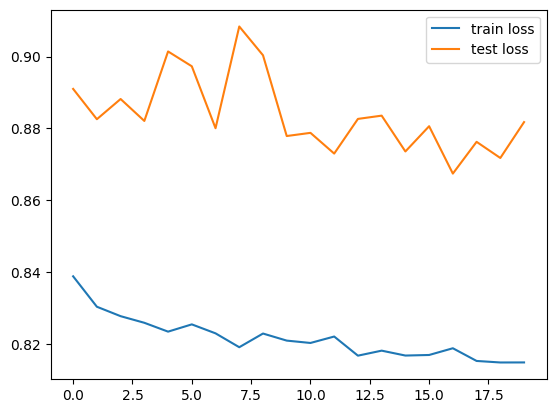

In [16]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend()
plt.show()

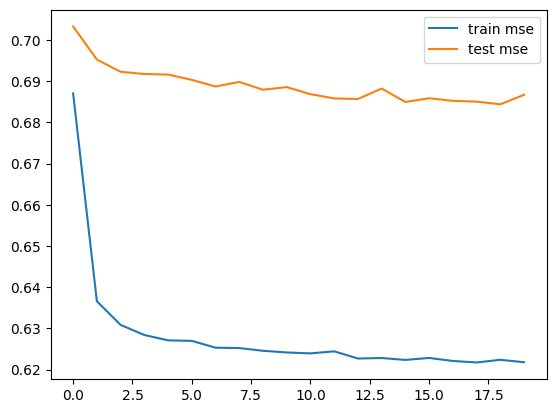

In [17]:
plt.plot(history.history['mse_loss'], label='train mse')
plt.plot(history.history['val_mse_loss'], label='test mse')
plt.legend()
plt.show()